# Try 1 Deterministic Based on Elo, Odds, etc

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Week 0: Action: no_bet, Odds: -285.0, Outcome: 1, Cumulative Reward: 0
Week 1: Action: bet, Odds: 1600.0, Outcome: -1, Cumulative Reward: -100
Week 2: Action: no_bet, Odds: 290.0, Outcome: -1, Cumulative Reward: -100
Week 3: Action: no_bet, Odds: 1200.0, Outcome: -1, Cumulative Reward: -100
Week 4: Action: bet, Odds: 340.0, Outcome: 1, Cumulative Reward: 240.0
Week 5: Action: no_bet, Odds: 550.0, Outcome: -1, Cumulative Reward: 240.0
Week 6: Action: no_bet, Odds: 1300.0, Outcome: -1, Cumulative Reward: 240.0
Week 7: Action: bet, Odds: 400.0, Outcome: 1, Cumulative Reward: 640.0
Week 8: Action: no_bet, Odds: 850.0, Outcome: -1, Cumulative Reward: 640.0
Week 9: Action: no_bet, Odds: 210.0, Outcome: -1, Cumulative Reward: 640.0
Week 10: Action: no_bet, Odds: 1100.0, Outcome: -1, Cumulative Reward: 640.0


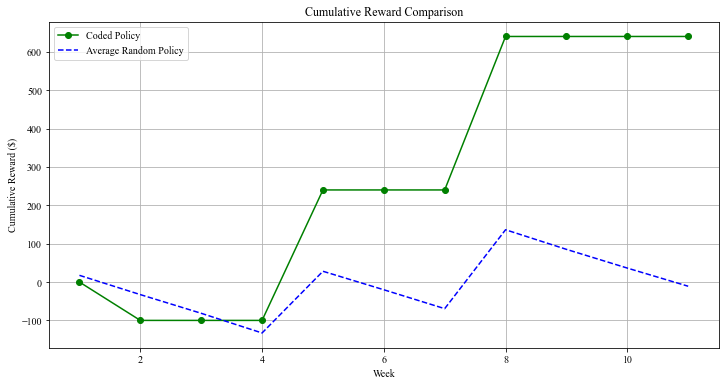

Times Coded Policy Beats Random Policies: 989


In [52]:
#Load data
data_df = pd.read_csv('./Data/2023/concat_stanford_2023.csv')

# Parameters
actions = ['bet', 'no_bet']
bet_amount = 100
expected_value_threshold = 5
num_simulations = 1000

# Define the reward function based on the bet outcome and odds
def reward(action, odds, outcome):
    if action == 'bet':
        if outcome > 0:  # Win scenario
            if odds > 0:
                return bet_amount * (odds / 100)  # Positive odds
            else:
                return bet_amount * (100 / abs(odds))  # Negative odds
        else:
            return -bet_amount  # Loss scenario
    return 0  # No reward if no bet

# Function to extract Stanford's moneyline odds and determine game outcome
def get_stanford_moneyline_and_outcome(row):
    if row['HomeTeam'] == 'Stanford':
        odds = row['HomeMoneyline']
        outcome = 1 if row['HomeScore'] > row['AwayScore'] else -1
        stanford_elo = row['Home Pregame Elo']
        opponent_elo = row['Away Pregame Elo']
    elif row['AwayTeam'] == 'Stanford':
        odds = row['AwayMoneyline']
        outcome = 1 if row['AwayScore'] > row['HomeScore'] else -1
        stanford_elo = row['Away Pregame Elo']
        opponent_elo = row['Home Pregame Elo']
    else:
        odds, outcome, stanford_elo, opponent_elo = None, None, None, None
    return odds, outcome, stanford_elo, opponent_elo

# Expected value calculation
def calculate_expected_value(odds, win_prob):
    if odds > 0:
        return bet_amount * (win_prob * (odds / 100) - (1 - win_prob))
    else:
        return bet_amount * (win_prob * (100 / abs(odds)) - (1 - win_prob))

# Simple policy to decide action based on Elo ratings comparison and expected value
def decide_action(row):
    odds, outcome, stanford_elo, opponent_elo = get_stanford_moneyline_and_outcome(row)
    if odds is None:
        return 'no_bet', 0  # Skip if Stanford did not play
    
    # Calculate win probability based on the Elo rating difference
    elo_diff = stanford_elo - opponent_elo
    win_prob = 1 / (1 + 10 ** (-elo_diff / 400))
    
    # Calculate expected value
    ev = calculate_expected_value(odds, win_prob)
    
    # Decision based on expected value
    if ev >= expected_value_threshold:
        return 'bet', odds
    else:
        return 'no_bet', odds

# Simulate the coded policy
coded_rewards = []
total_reward = 0
for week in range(len(data_df)):
    next_state = data_df.iloc[week]
    action, odds = decide_action(next_state)
    odds, outcome, _, _ = get_stanford_moneyline_and_outcome(next_state)
    week_reward = reward(action, odds, outcome)
    total_reward += week_reward
    coded_rewards.append(total_reward)
    print(f"Week {week}: Action: {action}, Odds: {odds}, Outcome: {outcome}, Cumulative Reward: {total_reward}")

# Simulate random policies
random_rewards = np.zeros((num_simulations, len(data_df)))
for sim in range(num_simulations):
    total_reward = 0
    for week in range(len(data_df)):
        next_state = data_df.iloc[week]
        odds, outcome, _, _ = get_stanford_moneyline_and_outcome(next_state)
        action = np.random.choice(actions)  # Random policy
        week_reward = reward(action, odds, outcome)
        total_reward += week_reward
        random_rewards[sim, week] = total_reward

# Calculate statistics
avg_random_rewards = random_rewards.mean(axis=0)
times_coded_beats_random = np.sum(coded_rewards[-1] > random_rewards[:, -1])

# Plot results
weeks = list(range(1, len(coded_rewards) + 1))
plt.figure(figsize=(12, 6))
plt.plot(weeks, coded_rewards, label="Coded Policy", marker='o', linestyle='-', color='g')
plt.plot(weeks, avg_random_rewards, label="Average Random Policy", linestyle='--', color='b')
plt.title("Cumulative Reward Comparison")
plt.xlabel("Week")
plt.ylabel("Cumulative Reward ($)")
plt.legend()
plt.grid(True)
plt.show()

print("Times Coded Policy Beats Random Policies:", times_coded_beats_random)

In [14]:
data_df.head(15)

,GameId,Week,Team,Opponent,Offense Plays,Offense Drives,Offense Ppa,Offense TotalPPA,Offense SuccessRate,Offense Explosiveness,...,AwayScore,LineProvider,OverUnder,Spread,FormattedSpread,OpeningSpread,OpeningOverUnder,HomeMoneyline,AwayMoneyline,Outcome
0,401523988,1,Stanford,Hawai'i,67,11,0.232013,15.544844,0.462687,1.241753,...,37,Bovada,54.5,2.5,Stanford -2.5,8.0,58.5,235.0,-285.0,1
1,401524003,2,Stanford,USC,66,14,-0.122133,-8.060770,0.393939,1.156977,...,10,Bovada,70.0,-28.5,USC -28.5,-30.0,71.0,-10000.0,1600.0,-1
2,401524016,4,Stanford,Arizona,66,10,0.153373,10.122589,0.409091,1.351993,...,21,Bovada,59.5,13.0,Arizona -13.0,10.0,59.0,290.0,-380.0,-1
3,401524024,5,Stanford,Oregon,70,9,-0.104485,-7.313962,0.357143,1.070678,...,42,Bovada,61.0,27.0,Oregon -27.0,27.0,61.0,1200.0,-4000.0,-1
4,401524029,7,Stanford,Colorado,86,14,0.255788,21.997803,0.476744,1.216817,...,46,Bovada,59.0,-13.0,Colorado -13.0,-11.5,59.0,-460.0,340.0,1
5,401524036,8,Stanford,UCLA,62,13,0.023353,1.447905,0.322581,1.309574,...,42,Bovada,51.5,17.0,UCLA -17.0,16.5,54.0,550.0,-850.0,-1
6,401524042,9,Stanford,Washington,80,14,0.296445,23.715596,0.487500,1.149510,...,42,Bovada,62.0,28.0,Washington -28.0,26.5,59.5,1300.0,-5000.0,-1
7,401524050,10,Stanford,Washington State,70,11,-0.062424,-4.369673,0.300000,1.056761,...,10,Bovada,58.0,-14.0,Washington State -14.0,-13.5,61.0,-575.0,400.0,1
8,401524054,11,Stanford,Oregon State,63,13,0.033653,2.120125,0.285714,1.958142,...,17,Bovada,52.5,-21.5,Oregon State -21.5,-20.5,54.5,-1800.0,850.0,-1
9,401524061,12,Stanford,California,57,12,0.040535,2.310467,0.298246,1.513605,...,27,Bovada,53.5,7.0,California -7.0,4.5,57.5,210.0,-250.0,-1


# Try 4 Q-learning Training

In [44]:
import pandas as pd

def preprocess_data(df):
    # Filter for Stanford games (either as home or away team)
    stanford_games = df[(df['HomeTeam'] == 'Stanford') | (df['AwayTeam'] == 'Stanford')]

    # Determine if Stanford is the home team
    stanford_games['IsHome'] = stanford_games['HomeTeam'] == 'Stanford'
    
    # Extract Stanford's Elo rating
    stanford_games['StanfordElo'] = stanford_games['Home Pregame Elo'].where(
        stanford_games['IsHome'], stanford_games['Away Pregame Elo']
    )
    
    # Extract opponent's Elo rating
    stanford_games['OpponentElo'] = stanford_games['Away Pregame Elo'].where(
        stanford_games['IsHome'], stanford_games['Home Pregame Elo']
    )
    
    # Calculate Elo difference (StanfordElo - OpponentElo)
    stanford_games['EloDiff'] = stanford_games['StanfordElo'] - stanford_games['OpponentElo']
    
    # Extract Stanford's Moneyline odds
    stanford_games['StanfordMoneyline'] = stanford_games['HomeMoneyline'].where(
        stanford_games['IsHome'], stanford_games['AwayMoneyline']
    )

    # Extract opponent's Moneyline odds
    stanford_games['OpponentMoneyline'] = stanford_games['AwayMoneyline'].where(
        stanford_games['IsHome'], stanford_games['HomeMoneyline']
    )
    
    # Determine Stanford's win/loss (1 for win, 0 for loss)
    stanford_games['StanfordWin'] = (
        ((stanford_games['HomeScore'] > stanford_games['AwayScore']) & stanford_games['IsHome']) |
        ((stanford_games['AwayScore'] > stanford_games['HomeScore']) & ~stanford_games['IsHome'])
    ).astype(int)

    # Add columns for opponent team and game location
    stanford_games['Opponent'] = stanford_games['AwayTeam'].where(
        stanford_games['IsHome'], stanford_games['HomeTeam']
    )
    stanford_games['Location'] = stanford_games['IsHome'].map({True: 'Home', False: 'Away'})

    # Keep only the relevant columns
    return stanford_games[
        ['Week', 'StanfordElo', 'OpponentElo', 'EloDiff', 'StanfordMoneyline', 
         'OpponentMoneyline', 'StanfordWin', 'Opponent', 'Location']
    ]

# Load CSV files
data_past = pd.read_csv("./Data/training_data.csv")  # Replace with the actual file path
data_2024 = pd.read_csv("./Data/2024/concat_stanford_2024.csv")  # Replace with the actual file path

# Preprocess the data
past_data_processed = preprocess_data(data_past)
season_2024_processed = preprocess_data(data_2024)

In [45]:
past_data_processed.head(50)

,Week,StanfordElo,OpponentElo,EloDiff,StanfordMoneyline,OpponentMoneyline,StanfordWin,Opponent,Location
0,1,1491,1447,44,140,-160,0,Kansas State,Away
1,2,1441,1672,-231,600,-1000,1,USC,Away
2,3,1497,1240,257,-470,345,1,Vanderbilt,Away
3,4,1515,1621,-106,160,-185,0,UCLA,Home
4,5,1501,1738,-237,255,-310,1,Oregon,Home
5,6,1525,1729,-204,375,-520,0,Arizona State,Away
6,7,1504,1472,32,-105,-115,0,Washington State,Away
7,9,1503,1665,-162,-145,125,0,Washington,Home
8,10,1502,1729,-227,265,-330,0,Utah,Home
9,11,1396,1515,-119,350,-480,0,Oregon State,Away


In [46]:
import numpy as np

# Define Q-learning parameters
learning_rate = 0.1
discount_factor = 0.9
epsilon = 0.1
num_episodes = 1000
bet_amount = 100  # Fixed bet amount

# Initialize Q-table with default values
q_table = {}

# Define a function to initialize the Q-table with default values
def initialize_q_table(states, actions):
    for state in states:
        if state not in q_table:
            q_table[state] = {action: 0 for action in actions}

# Define reward function
def reward(action, odds, outcome):
    """
    Calculate reward based on the action taken, odds, and the outcome.
    
    :param action: 'bet' if the bettor placed a bet, 'no_bet' otherwise
    :param odds: The odds for Stanford's moneyline
    :param outcome: 1 if Stanford wins, 0 if Stanford loses
    :return: The reward for the action taken
    """
    if action == 'bet':  # Bet placed
        if outcome == 1:  # Win scenario
            # If odds are positive
            if odds > 0:
                return bet_amount * (odds / 100)
            # If odds are negative
            else:
                return bet_amount * (100 / abs(odds))
        else:  # Loss scenario
            return -bet_amount
    return 0  # No reward for no_bet

# Initialize Q-table with states from past data
states = past_data_processed[['EloDiff', 'StanfordMoneyline']].values
actions = [0, 1]  # 0: No bet, 1: Bet $100

# Initialize Q-table for all possible states
initialize_q_table(map(tuple, states), actions)

# Q-learning algorithm with state-action initialization
def q_learning(past_data):
    for episode in range(num_episodes):
        for index, row in past_data.iterrows():
            # Define current state (EloDiff, StanfordMoneyline)
            state = (row['EloDiff'], row['StanfordMoneyline'])

            # Initialize state-action pair if not already in Q-table
            if state not in q_table:
                q_table[state] = {action: 0 for action in actions}

            # Choose action using epsilon-greedy policy
            if np.random.rand() < epsilon:
                action = np.random.choice(actions)  # Explore
            else:
                action = max(q_table[state], key=q_table[state].get)  # Exploit

            # Convert action to human-readable form for reward calculation
            action_str = 'bet' if action == 1 else 'no_bet'

            # Get the Stanford moneyline odds (assuming Stanford is the home team)
            odds = row['StanfordMoneyline']
            
            # Get the game outcome (StanfordWin)
            outcome = row['StanfordWin']

            # Calculate the reward using the refined reward function
            reward_value = reward(action_str, odds, outcome)

            # Determine next state
            if index + 1 < len(past_data):
                next_row = past_data.iloc[index + 1]
                next_state = (next_row['EloDiff'], next_row['StanfordMoneyline'])
            else:
                next_state = None

            # Update Q-value
            if next_state:
                if next_state not in q_table:
                    q_table[next_state] = {action: 0 for action in actions}
                q_table[state][action] += learning_rate * (
                    reward_value + discount_factor * max(q_table[next_state].values()) - q_table[state][action]
                )
            else:
                q_table[state][action] += learning_rate * (reward_value - q_table[state][action])

    return q_table

# Train Q-learning model
trained_q_table = q_learning(past_data_processed)

Game Week 1:
  State: (-301.0, 250.0)
  Action: no_bet
  Winner: Opponent
  Reward: 0
  Cumulative Reward: 0
--------------------------------------------------
Game Week 2:
  State: (-91.0, 265.0)
  Action: bet
  Winner: Stanford
  Reward: 265.0
  Cumulative Reward: 265.0
--------------------------------------------------
Game Week 3:
  State: (-487.0, 900.0)
  Action: no_bet
  Winner: Opponent
  Reward: 0
  Cumulative Reward: 265.0
--------------------------------------------------
Game Week 4:
  State: (-329.0, 255.0)
  Action: no_bet
  Winner: Opponent
  Reward: 0
  Cumulative Reward: 265.0
--------------------------------------------------
Game Week 5:
  State: (-733.0, 1000.0)
  Action: no_bet
  Winner: Opponent
  Reward: 0
  Cumulative Reward: 265.0
--------------------------------------------------
Game Week 6:
  State: (-536.0, 460.0)
  Action: bet
  Winner: Opponent
  Reward: -100
  Cumulative Reward: 165.0
--------------------------------------------------
Game Week 7:
  Stat

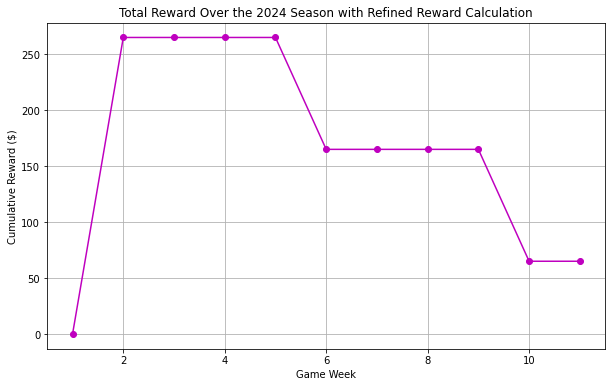

In [47]:
import matplotlib.pyplot as plt
from scipy.spatial import cKDTree

def interpolate_q_value(state, q_table, all_states, actions):
    """
    Interpolates Q-values for a state not explicitly in the Q-table.
    Uses nearest neighbor interpolation.
    
    :param state: The current state
    :param q_table: The trained Q-table
    :param all_states: All known states from training
    :param actions: The list of possible actions
    :return: Interpolated Q-values for the state
    """
    # Build KD-tree for fast nearest neighbor search
    kdtree = cKDTree(all_states)
    _, nearest_idx = kdtree.query(state)
    nearest_state = all_states[nearest_idx]
    
    # Return Q-values of the nearest state
    if tuple(nearest_state) in q_table:
        return q_table[tuple(nearest_state)]
    else:
        return {action: 0 for action in actions}  # Default values

def simulate_season_with_winner_printed(q_table, season_data, all_states, actions):
    total_reward = 0
    rewards = []  # Store rewards over weeks
    
    for index, row in season_data.iterrows():
        # Define current state (EloDiff, StanfordMoneyline)
        state = (row['EloDiff'], row['StanfordMoneyline'])

        # Extrapolate or retrieve Q-values for the current state
        action_values = interpolate_q_value(state, q_table, all_states, actions)

        # Choose action using the interpolated Q-values
        action = max(action_values, key=action_values.get)  # Exploit learned policy

        # Convert action to human-readable form
        action_str = 'bet' if action == 1 else 'no_bet'

        # Determine the winner based on the 'StanfordWin' column
        outcome = row['StanfordWin']

        # Get the Stanford moneyline odds (Stanford's odds are in the correct column)
        odds = row['StanfordMoneyline']

        # Calculate the reward using the refined reward function
        reward_value = reward(action_str, odds, outcome)

        # Update total reward
        total_reward += reward_value

        # Print current week details
        print(f"Game Week {index + 1}:")
        print(f"  State: {state}")
        print(f"  Action: {action_str}")
        print(f"  Winner: {'Stanford' if outcome == 1 else 'Opponent'}")
        print(f"  Reward: {reward_value}")
        print(f"  Cumulative Reward: {total_reward}")
        print("-" * 50)

        # Append weekly reward
        rewards.append(total_reward)

    return rewards

# Prepare all_states for interpolation
all_states = np.array(list(q_table.keys()))

# Run the simulation with the updated reward function
rewards_2024_winner_printed = simulate_season_with_winner_printed(
    trained_q_table, season_2024_processed, all_states, actions
)

# Plot rewards over game weeks
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(rewards_2024_winner_printed) + 1), rewards_2024_winner_printed, marker='o', linestyle='-', color='m')
plt.title("Total Reward Over the 2024 Season with Refined Reward Calculation")
plt.xlabel("Game Week")
plt.ylabel("Cumulative Reward ($)")
plt.grid(True)
plt.show()

In [48]:
print(season_2024_processed.columns)

Index(['Week', 'StanfordElo', 'OpponentElo', 'EloDiff', 'StanfordMoneyline',
       'OpponentMoneyline', 'StanfordWin', 'Opponent', 'Location'],
      dtype='object')


In [49]:
def simulate_random_policy(season_data):
    """
    Simulates a random policy for the given season data.
    Returns the cumulative reward from the random policy.
    
    :param season_data: The processed season data
    :return: Cumulative reward for the random policy
    """
    total_reward = 0
    for index, row in season_data.iterrows():
        # Randomly choose an action: 0 for no bet, 1 for bet
        action = np.random.choice([0, 1])
        action_str = 'bet' if action == 1 else 'no_bet'
        
        # Get the outcome and odds
        outcome = row['StanfordWin']
        odds = row['StanfordMoneyline']
        
        # Calculate the reward for the random action
        reward_value = reward(action_str, odds, outcome)
        total_reward += reward_value
    
    return total_reward

# Number of random policies to simulate
num_random_policies = 1000

# Simulate the Q-learning policy for comparison
rewards_q_learning = sum(reward > 0 for reward in rewards_2024_winner_printed)

# Simulate random policies
random_policy_rewards = []
for _ in range(num_random_policies):
    random_policy_reward = simulate_random_policy(season_2024_processed)
    random_policy_rewards.append(random_policy_reward)

# Count how many times Q-learning outperformed random policies
q_learning_better_count = sum(rewards_q_learning > reward for reward in random_policy_rewards)

# Display results
print(f"Q-learning policy total reward: {rewards_2024_winner_printed[-1]}")
print(f"Q-learning policy outperformed random policy in {q_learning_better_count}/{num_random_policies} simulations.")

Q-learning policy total reward: 65.0
Q-learning policy outperformed random policy in 498/1000 simulations.


# Try 5 Guaranteed Bet

In [27]:
import pandas as pd

def preprocess_data(df):
    # Filter for Stanford games (either as home or away team)
    stanford_games = df[(df['HomeTeam'] == 'Stanford') | (df['AwayTeam'] == 'Stanford')]

    # Determine if Stanford is the home team
    stanford_games['IsHome'] = stanford_games['HomeTeam'] == 'Stanford'
    
    # Extract Stanford's Elo rating
    stanford_games['StanfordElo'] = stanford_games['Home Pregame Elo'].where(
        stanford_games['IsHome'], stanford_games['Away Pregame Elo']
    )
    
    # Extract opponent's Elo rating
    stanford_games['OpponentElo'] = stanford_games['Away Pregame Elo'].where(
        stanford_games['IsHome'], stanford_games['Home Pregame Elo']
    )
    
    # Calculate Elo difference (StanfordElo - OpponentElo)
    stanford_games['EloDiff'] = stanford_games['StanfordElo'] - stanford_games['OpponentElo']
    
    # Extract Stanford's Moneyline odds
    stanford_games['StanfordMoneyline'] = stanford_games['HomeMoneyline'].where(
        stanford_games['IsHome'], stanford_games['AwayMoneyline']
    )

    # Extract opponent's Moneyline odds
    stanford_games['OpponentMoneyline'] = stanford_games['AwayMoneyline'].where(
        stanford_games['IsHome'], stanford_games['HomeMoneyline']
    )
    
    # Determine Stanford's win/loss (1 for win, 0 for loss)
    stanford_games['StanfordWin'] = (
        ((stanford_games['HomeScore'] > stanford_games['AwayScore']) & stanford_games['IsHome']) |
        ((stanford_games['AwayScore'] > stanford_games['HomeScore']) & ~stanford_games['IsHome'])
    ).astype(int)

    # Add columns for opponent team and game location
    stanford_games['Opponent'] = stanford_games['AwayTeam'].where(
        stanford_games['IsHome'], stanford_games['HomeTeam']
    )
    stanford_games['Location'] = stanford_games['IsHome'].map({True: 'Home', False: 'Away'})

    # Keep only the relevant columns
    return stanford_games[
        ['Week', 'StanfordElo', 'OpponentElo', 'EloDiff', 'StanfordMoneyline', 
         'OpponentMoneyline', 'StanfordWin', 'Opponent', 'Location']
    ]

# Load CSV files
data_past = pd.read_csv("./Data/training_data.csv")  # Replace with the actual file path
data_2024 = pd.read_csv("./Data/2024/concat_stanford_2024.csv")  # Replace with the actual file path

# Preprocess the data
past_data_processed = preprocess_data(data_past)
season_2024_processed = preprocess_data(data_2024)

In [28]:
past_data_processed.head(50)

,Week,StanfordElo,OpponentElo,EloDiff,StanfordMoneyline,OpponentMoneyline,StanfordWin,Opponent,Location
0,1,1491,1447,44,140,-160,0,Kansas State,Away
1,2,1441,1672,-231,600,-1000,1,USC,Away
2,3,1497,1240,257,-470,345,1,Vanderbilt,Away
3,4,1515,1621,-106,160,-185,0,UCLA,Home
4,5,1501,1738,-237,255,-310,1,Oregon,Home
5,6,1525,1729,-204,375,-520,0,Arizona State,Away
6,7,1504,1472,32,-105,-115,0,Washington State,Away
7,9,1503,1665,-162,-145,125,0,Washington,Home
8,10,1502,1729,-227,265,-330,0,Utah,Home
9,11,1396,1515,-119,350,-480,0,Oregon State,Away


In [37]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import cKDTree

# Define Q-learning parameters
learning_rate = 0.1
discount_factor = 0.9
epsilon = 0.1
num_episodes = 1000
bet_amount = 100  # Fixed bet amount

# Initialize Q-table with default values
q_table = {}

# Initialize the Q-table with default values for each state-action pair
def initialize_q_table(states, actions):
    for state in states:
        if state not in q_table:
            q_table[state] = {action: 0 for action in actions}

# Define reward function
def reward(action, odds_stanford, odds_opponent, outcome):
    """
    Calculate reward based on the action taken, odds, and the outcome.
    
    :param action: Action taken ('bet_stanford', 'bet_opponent')
    :param odds_stanford: Moneyline odds for Stanford
    :param odds_opponent: Moneyline odds for the opponent
    :param outcome: 1 if Stanford wins, 0 if Stanford loses
    :return: The reward for the action taken
    """
    if action == 'bet_stanford':  # Bet on Stanford
        if outcome == 1:  # Stanford wins
            if odds_stanford > 0:
                return bet_amount * (odds_stanford / 100)
            else:
                return bet_amount * (100 / abs(odds_stanford))
        else:  # Stanford loses
            return -bet_amount
    elif action == 'bet_opponent':  # Bet on the opponent
        if outcome == 0:  # Opponent wins
            if odds_opponent > 0:
                return bet_amount * (odds_opponent / 100)
            else:
                return bet_amount * (100 / abs(odds_opponent))
        else:  # Opponent loses
            return -bet_amount
    return 0  # No other actions possible

# Initialize Q-table with states from past data
states = past_data_processed[['EloDiff', 'StanfordMoneyline', 'OpponentMoneyline']].values
actions = ['bet_stanford', 'bet_opponent']  # Action space

# Initialize Q-table for all possible states
initialize_q_table(map(tuple, states), actions)

# Q-learning algorithm with state-action initialization
def q_learning(past_data):
    for episode in range(num_episodes):
        for index, row in past_data.iterrows():
            # Define current state (EloDiff, StanfordMoneyline, OpponentMoneyline)
            state = (row['EloDiff'], row['StanfordMoneyline'], row['OpponentMoneyline'])

            # Initialize state-action pair if not already in Q-table
            if state not in q_table:
                q_table[state] = {action: 0 for action in actions}

            # Choose action using epsilon-greedy policy
            if np.random.rand() < epsilon:
                action = np.random.choice(actions)  # Explore
            else:
                action = max(q_table[state], key=q_table[state].get)  # Exploit

            # Get odds and outcome
            odds_stanford = row['StanfordMoneyline']
            odds_opponent = row['OpponentMoneyline']
            outcome = row['StanfordWin']  # 1 if Stanford wins, 0 otherwise

            # Calculate the reward
            reward_value = reward(action, odds_stanford, odds_opponent, outcome)

            # Determine next state
            if index + 1 < len(past_data):
                next_row = past_data.iloc[index + 1]
                next_state = (
                    next_row['EloDiff'], 
                    next_row['StanfordMoneyline'], 
                    next_row['OpponentMoneyline']
                )
            else:
                next_state = None

            # Update Q-value
            if next_state:
                if next_state not in q_table:
                    q_table[next_state] = {action: 0 for action in actions}
                q_table[state][action] += learning_rate * (
                    reward_value + discount_factor * max(q_table[next_state].values()) - q_table[state][action]
                )
            else:
                q_table[state][action] += learning_rate * (reward_value - q_table[state][action])

    return q_table

# Train Q-learning model
trained_q_table = q_learning(past_data_processed)

Game Week 1:
  State: (-301.0, 250.0, -300.0)
  Action: bet_opponent
  Winner: Opponent
  Reward: 33.33333333333333
  Cumulative Reward: 33.33333333333333
--------------------------------------------------
Game Week 2:
  State: (-91.0, 265.0, -330.0)
  Action: bet_opponent
  Winner: Stanford
  Reward: -100
  Cumulative Reward: -66.66666666666667
--------------------------------------------------
Game Week 3:
  State: (-487.0, 900.0, -1900.0)
  Action: bet_opponent
  Winner: Opponent
  Reward: 5.263157894736842
  Cumulative Reward: -61.40350877192983
--------------------------------------------------
Game Week 4:
  State: (-329.0, 255.0, -310.0)
  Action: bet_opponent
  Winner: Opponent
  Reward: 32.25806451612903
  Cumulative Reward: -29.145444255800797
--------------------------------------------------
Game Week 5:
  State: (-733.0, 1000.0, -2200.0)
  Action: bet_opponent
  Winner: Opponent
  Reward: 4.545454545454546
  Cumulative Reward: -24.59998971034625
---------------------------

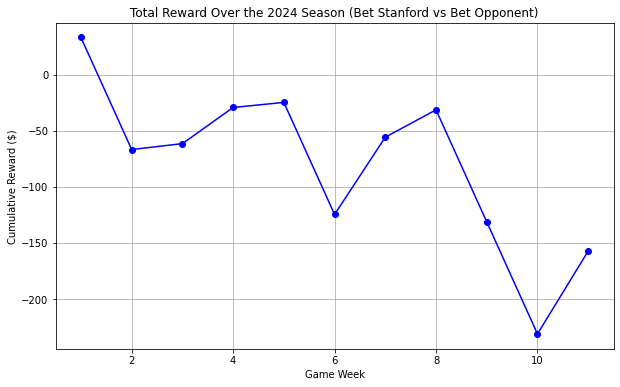

In [42]:
# Function to interpolate Q-values
def interpolate_q_value(state, q_table, all_states, actions):
    kdtree = cKDTree(all_states)
    _, nearest_idx = kdtree.query(state)
    nearest_state = all_states[nearest_idx]
    if tuple(nearest_state) in q_table:
        return q_table[tuple(nearest_state)]
    else:
        return {action: 0 for action in actions}

# Simulate the season
def simulate_season(q_table, season_data, all_states, actions):
    total_reward = 0
    rewards = []

    for index, row in season_data.iterrows():
        state = (row['EloDiff'], row['StanfordMoneyline'], row['OpponentMoneyline'])
        action_values = interpolate_q_value(state, q_table, all_states, actions)
        action = max(action_values, key=action_values.get)  # Exploit
        odds_stanford = row['StanfordMoneyline']
        odds_opponent = row['OpponentMoneyline']
        outcome = row['StanfordWin']
        reward_value = reward(action, odds_stanford, odds_opponent, outcome)
        total_reward += reward_value
        rewards.append(total_reward)
        
        # Print current week details
        print(f"Game Week {index + 1}:")
        print(f"  State: {state}")
        print(f"  Action: {action}")
        print(f"  Winner: {'Stanford' if outcome == 1 else 'Opponent'}")
        print(f"  Reward: {reward_value}")
        print(f"  Cumulative Reward: {total_reward}")
        print("-" * 50)

    return rewards

# Prepare all_states for interpolation
all_states = np.array(list(q_table.keys()))

# Run the simulation
rewards_2024 = simulate_season(trained_q_table, season_2024_processed, all_states, actions)

# Plot cumulative rewards over the season
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(rewards_2024) + 1), rewards_2024, marker='o', linestyle='-', color='b')
plt.title("Total Reward Over the 2024 Season (Bet Stanford vs Bet Opponent)")
plt.xlabel("Game Week")
plt.ylabel("Cumulative Reward ($)")
plt.grid(True)
plt.show()

In [39]:
print(season_2024_processed.columns)

Index(['Week', 'StanfordElo', 'OpponentElo', 'EloDiff', 'StanfordMoneyline',
       'OpponentMoneyline', 'StanfordWin', 'Opponent', 'Location'],
      dtype='object')


In [40]:
def simulate_random_policy(season_data):
    """
    Simulates a random policy for the given season data.
    Returns the cumulative reward from the random policy.
    
    :param season_data: The processed season data
    :return: Cumulative reward for the random policy
    """
    total_reward = 0
    for index, row in season_data.iterrows():
        # Randomly choose an action: 0 for no bet, 1 for bet
        action = np.random.choice([0, 1])
        action_str = 'bet' if action == 1 else 'no_bet'
        
        # Get the outcome and odds
        outcome = row['StanfordWin']
        odds = row['StanfordMoneyline']
        
        # Calculate the reward for the random action
        reward_value = reward(action_str, odds, outcome)
        total_reward += reward_value
    
    return total_reward

# Number of random policies to simulate
num_random_policies = 1000

# Simulate the Q-learning policy for comparison
rewards_q_learning = sum(reward > 0 for reward in rewards_2024_winner_printed)

# Simulate random policies
random_policy_rewards = []
for _ in range(num_random_policies):
    random_policy_reward = simulate_random_policy(season_2024_processed)
    random_policy_rewards.append(random_policy_reward)

# Count how many times Q-learning outperformed random policies
q_learning_better_count = sum(rewards_q_learning > reward for reward in random_policy_rewards)

# Display results
print(f"Q-learning policy total reward: {rewards_2024_winner_printed[-1]}")
print(f"Q-learning policy outperformed random policy in {q_learning_better_count}/{num_random_policies} simulations.")

TypeError: reward() missing 1 required positional argument: 'outcome'

# Try 6 Q-learning from Scratch

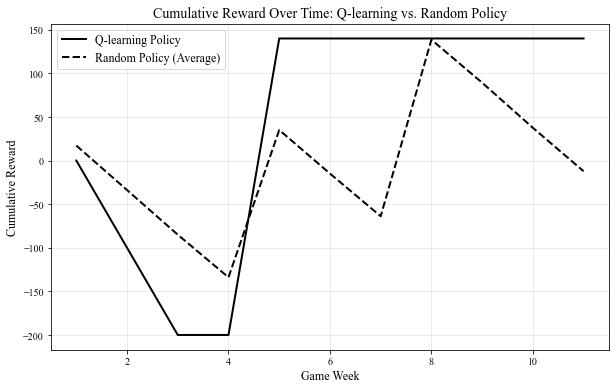

Q-learning beats Random Policy in 718/1000 simulations.
Q-learning Total Reward: 140.0
Random Policy Average Reward: -17.45929824561404
Random Policy Standard Deviation: 291.3045388761337

Q-learning Decisions for Each Game Week:
 Week          Action  Reward
    1          No Bet     0.0
    2 Bet on Stanford  -100.0
    3 Bet on Stanford  -100.0
    4          No Bet     0.0
    5 Bet on Stanford   340.0
    6          No Bet     0.0
    7          No Bet     0.0
    8          No Bet     0.0
    9          No Bet     0.0
   10          No Bet     0.0
   11          No Bet     0.0


In [51]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Load the data
training_data_path = './data/training_data.csv'
season_2024_data_path = './data/2023/concat_stanford_2023.csv'

training_data = pd.read_csv(training_data_path)
season_2024_data = pd.read_csv(season_2024_data_path)

# Define all columns to use as features (state space)
state_columns = [
    'Offense Ppa', 'Offense TotalPPA', 'Offense SuccessRate', 'Offense Explosiveness', 'Offense PowerSuccess',
    'Offense StuffRate', 'Offense LineYards', 'Offense LineYardsTotal', 'Offense SecondLevelYards',
    'Offense SecondLevelYardsTotal', 'Offense OpenFieldYards', 'Offense OpenFieldYardsTotal',
    'Offense StandardDowns Ppa', 'Offense StandardDowns SuccessRate', 'Offense StandardDowns Explosiveness',
    'Offense PassingDowns Ppa', 'Offense PassingDowns SuccessRate', 'Offense PassingDowns Explosiveness',
    'Offense RushingPlays Ppa', 'Offense RushingPlays TotalPPA', 'Offense RushingPlays SuccessRate',
    'Offense RushingPlays Explosiveness', 'Offense PassingPlays Ppa', 'Offense PassingPlays TotalPPA',
    'Offense PassingPlays SuccessRate', 'Offense PassingPlays Explosiveness', 'Defense Plays', 'Defense Drives',
    'Defense Ppa', 'Defense TotalPPA', 'Defense SuccessRate', 'Defense Explosiveness', 'Defense PowerSuccess',
    'Defense StuffRate', 'Defense LineYards', 'Defense LineYardsTotal', 'Defense SecondLevelYards',
    'Defense SecondLevelYardsTotal', 'Defense OpenFieldYards', 'Defense OpenFieldYardsTotal',
    'Defense StandardDowns Ppa', 'Defense StandardDowns SuccessRate', 'Defense StandardDowns Explosiveness',
    'Defense PassingDowns Ppa', 'Defense PassingDowns SuccessRate', 'Defense PassingDowns Explosiveness',
    'Defense RushingPlays Ppa', 'Defense RushingPlays TotalPPA', 'Defense RushingPlays SuccessRate',
    'Defense RushingPlays Explosiveness', 'Defense PassingPlays Ppa', 'Defense PassingPlays TotalPPA',
    'Defense PassingPlays SuccessRate', 'Defense PassingPlays Explosiveness', 'Home Pregame Elo',
    'Away Pregame Elo', 'Spread', 'OverUnder', 'HomeMoneyline', 'AwayMoneyline',
    'fumblesRecovered', 'rushingTDs', 'punReturnTDs', 'puntReturns', 'passingTDs', 'kickReturnYards',
    'kickReturnTDs', 'kickReturns', 'kickingPoints', 'interceptionYards', 'interceptionTDs', 'passesIntercepted',
    'tacklesForLoss', 'defensiveTDs', 'tackles', 'sacks', 'qbHurries', 'passesDeflected', 'possessionTime',
    'interceptions', 'fumblesLost', 'turnovers', 'totalPenaltiesYards', 'yardsPerRushAttempt', 
    'rushingAttempts', 'rushingYards', 'yardsPerPass', 'completionAttempts', 'netPassingYards', 'totalYards',
    'fourthDownEff', 'thirdDownEff', 'firstDowns', 'totalFumbles', 'Outcome', 'IsHome'
]

state_columns = [col for col in state_columns if col in training_data.columns]

training_data_relevant = training_data[state_columns].copy()
season_2024_relevant = season_2024_data[state_columns].copy()

training_data_relevant["IsHome"] = training_data["Team"] == training_data["Home Team"]
season_2024_relevant["IsHome"] = season_2024_data["Team"] == season_2024_data["Home Team"]

# Conversion function
def convert_fraction_to_float(value):
    try:
        if isinstance(value, str) and '-' in value:
            numerator, denominator = map(float, value.split('-'))
            return numerator / denominator if denominator != 0 else 0  # Avoid division by zero
        else:
            return float(value)
    except ValueError:
        return np.nan  # Handle invalid values

# List of columns to check for fractions
fraction_columns = ['totalPenaltiesYards', 'completionAttempts', 'fourthDownEff']  # Add other columns with this issue if needed

# Apply conversion
for col in fraction_columns:
    training_data_relevant[col] = training_data_relevant[col].apply(convert_fraction_to_float)
    season_2024_relevant[col] = season_2024_relevant[col].apply(convert_fraction_to_float)

# Fill missing values (e.g., from invalid conversions)
training_data_relevant = training_data_relevant.fillna(0)
season_2024_relevant = season_2024_relevant.fillna(0)

# Normalize the state features
scaler = MinMaxScaler()
training_data_normalized = scaler.fit_transform(training_data_relevant[state_columns])
season_2024_normalized = scaler.transform(season_2024_relevant[state_columns])

# Initialize the Q-table
num_states = training_data_normalized.shape[0]
num_actions = 2
q_table = np.zeros((num_states, num_actions))

# Define the reward function
def calculate_reward(is_home, home_moneyline, away_moneyline, outcome, action):
    if action == 0:
        return 0
    moneyline = home_moneyline if is_home else away_moneyline
    if outcome == 1:
        return abs(100 / moneyline) * 100 if moneyline < 0 else (moneyline / 100) * 100
    else:
        return -100

# Q-learning training
learning_rate = 0.1
discount_factor = 0.9
epsilon = 0.1

for episode in range(1000):
    for i, row in enumerate(training_data_normalized):
        state = i
        if np.random.uniform(0, 1) < epsilon:
            action = np.random.choice([0, 1])
        else:
            action = np.argmax(q_table[state, :])

        original_row = training_data_relevant.iloc[state]
        reward = calculate_reward(
            original_row["IsHome"], original_row["HomeMoneyline"], original_row["AwayMoneyline"], original_row["Outcome"], action
        )
        next_state = state + 1 if state + 1 < num_states else state
        q_table[state, action] += learning_rate * (
            reward + discount_factor * np.max(q_table[next_state, :]) - q_table[state, action]
        )

# Simulation of the 2024 season
def simulate_season(policy, data, log_decisions=False):
    total_reward = 0
    decisions = []
    for i, row in enumerate(data):
        action = policy(i, q_table)  # Policy determines action
        original_row = season_2024_relevant.iloc[i]
        reward = calculate_reward(
            original_row["IsHome"], original_row["HomeMoneyline"], original_row["AwayMoneyline"], original_row["Outcome"], action
        )
        total_reward += reward
        if log_decisions:
            decisions.append({
                "Week": i + 1,
                "Action": "Bet on Stanford" if action == 1 else "No Bet",
                "Reward": reward
            })
    return total_reward, decisions

# Q-learning policy
def q_learning_policy(state, q_table):
    return np.argmax(q_table[state, :])

# Random policy
def random_policy(state, q_table):
    return np.random.choice([0, 1])

# Compare Q-learning vs Random
q_learning_rewards, q_learning_decisions = simulate_season(q_learning_policy, season_2024_normalized, log_decisions=True)
# Simulate the season and collect rewards for Random policy across multiple runs
random_rewards_per_week = []

# Run simulations for Random policy
for _ in range(1000):
    _, random_decisions = simulate_season(random_policy, season_2024_normalized, log_decisions=True)
    rewards_for_one_run = [decision["Reward"] for decision in random_decisions]
    random_rewards_per_week.append(rewards_for_one_run)

# Convert to numpy array for easier averaging
random_rewards_per_week = np.array(random_rewards_per_week)

# Calculate the average cumulative reward per week across all random simulations
average_random_rewards = np.mean(random_rewards_per_week, axis=0)
cumulative_random_rewards = np.cumsum(average_random_rewards)

# Cumulative rewards for Q-learning
q_learning_cumulative_rewards = np.cumsum([decision["Reward"] for decision in q_learning_decisions])

plt.figure(figsize=(10, 6))

# Set the font to Times New Roman
plt.rcParams["font.family"] = "Times New Roman"

# Plot cumulative rewards for Q-learning
plt.plot(
    range(1, len(q_learning_cumulative_rewards) + 1),
    q_learning_cumulative_rewards,
    label="Q-learning Policy",
    color="black",
    linewidth=2,
)

# Plot cumulative rewards for Random policy (averaged)
plt.plot(
    range(1, len(cumulative_random_rewards) + 1),
    cumulative_random_rewards,
    label="Random Policy (Average)",
    color="black",
    linestyle="--",
    linewidth=2,
)

# Add labels, title, and legend
plt.title("Cumulative Reward Over Time: Q-learning vs. Random Policy", fontsize=14)
plt.xlabel("Game Week", fontsize=12)
plt.ylabel("Cumulative Reward", fontsize=12)
plt.legend(fontsize=12)
plt.grid(alpha=0.3)

# Display the plot
plt.show()

# Calculate statistics
q_learning_better_count = sum(q_learning_rewards > r for r in random_rewards)
print(f"Q-learning beats Random Policy in {q_learning_better_count}/1000 simulations.")
print(f"Q-learning Total Reward: {q_learning_rewards}")
print(f"Random Policy Average Reward: {np.mean(random_rewards)}")
print(f"Random Policy Standard Deviation: {np.std(random_rewards)}")

# Print Q-learning decisions
q_learning_decisions_df = pd.DataFrame(q_learning_decisions)
print("\nQ-learning Decisions for Each Game Week:")
print(q_learning_decisions_df.to_string(index=False))

In [45]:
season_2024_relevant.head(15)

,Offense Ppa,Offense TotalPPA,Offense SuccessRate,Offense Explosiveness,Offense PowerSuccess,Offense StuffRate,Offense LineYards,Offense LineYardsTotal,Offense SecondLevelYards,Offense SecondLevelYardsTotal,...,yardsPerPass,completionAttempts,netPassingYards,totalYards,fourthDownEff,thirdDownEff,firstDowns,totalFumbles,Outcome,IsHome
0,0.23,15.54,0.46,1.24,0.56,0.24,2.65,88.0,0.97,32.0,...,6.9,0.694444,248.0,406.0,0.0,45457.0,24.0,0.0,1.0,False
1,-0.12,-8.06,0.39,1.16,0.33,0.23,1.88,74.0,1.13,44.0,...,5.6,45590.000000,140.0,349.0,0.0,45395.0,20.0,4.0,-1.0,False
2,0.15,10.12,0.41,1.35,1.00,0.24,2.54,74.0,0.97,28.0,...,7.7,0.562500,246.0,358.0,45292.0,45489.0,19.0,1.0,-1.0,True
3,-0.10,-7.31,0.36,1.07,0.50,0.20,2.27,93.0,0.73,30.0,...,5.5,0.583333,133.0,222.0,45357.0,45461.0,16.0,1.0,-1.0,True
4,0.26,22.00,0.48,1.22,1.00,0.17,3.19,115.0,0.97,35.0,...,8.1,0.571429,399.0,523.0,0.0,45583.0,29.0,2.0,1.0,False
5,0.02,1.45,0.32,1.31,0.00,0.36,2.05,29.0,1.43,20.0,...,6.0,0.600000,268.0,292.0,0.0,45302.0,15.0,1.0,-1.0,True
6,0.30,23.72,0.49,1.15,0.71,0.07,3.56,107.0,1.03,31.0,...,7.2,0.607843,367.0,495.0,45294.0,45428.0,26.0,1.0,-1.0,True
7,-0.06,-4.37,0.30,1.06,0.71,0.28,2.13,77.0,0.53,19.0,...,4.4,0.500000,142.0,217.0,45325.0,45461.0,18.0,0.0,1.0,False
8,0.03,2.12,0.29,1.96,0.00,0.31,2.33,61.0,1.12,29.0,...,7.6,0.437500,242.0,324.0,0.0,45364.0,18.0,2.0,-1.0,False
9,0.04,2.31,0.30,1.51,1.00,0.24,3.17,67.0,1.33,28.0,...,5.4,0.514286,188.0,289.0,45293.0,45428.0,12.0,2.0,-1.0,True
